In [19]:
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score, classification_report
pd.set_option('display.max_columns',None)
import joblib

In [21]:
price_data = pd.read_parquet(f'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/Dados_bolsa_interpolar.parquet')
price_data.head()


,Date,Open,High,Low,Close,Adj Close,Volume,Ticker
0,2000-01-05,0.520882,0.520882,0.520882,0.520882,0.291125,985,ABEV3.SA
1,2000-01-06,0.494478,0.494478,0.494478,0.494478,0.276367,227,ABEV3.SA
2,2000-01-12,0.481293,0.481293,0.481293,0.481293,0.268998,1137,ABEV3.SA
3,2000-01-13,0.484589,0.484589,0.484589,0.484589,0.270840,606,ABEV3.SA
4,2000-01-14,0.494478,0.494478,0.494478,0.494478,0.276367,6445,ABEV3.SA


In [22]:
# Configuração inicial
price_data['Date'] = pd.to_datetime(price_data['Date'])
price_data.sort_values(by=['Ticker', 'Date'], inplace=True)

# Cálculo da mudança no preço
price_data['change_in_price'] = price_data['Close'].diff()
mask = price_data['Ticker'] != price_data['Ticker'].shift(1)
price_data['change_in_price'] = np.where(mask, np.nan, price_data['change_in_price'])
price_data[price_data.isna().any(axis = 1)]

# Função de suavização exponencial
def exponential_smoothing(data, alpha):
    smoothed = np.zeros(len(data))
    smoothed[0] = data[0]
    for t in range(1, len(data)):
        smoothed[t] = alpha * data[t] + (1 - alpha) * smoothed[t-1]
    return smoothed

# Função para calcular o target
def calculate_target(data, d):
    return np.sign(data.shift(-d) - data)

# Função para calcular o target e ajustar valores zero para -1
def calculate_target_verify(data, d):
    target = np.sign(data.shift(-d) - data)
    target[target == 0] = -1
    return target

def obv(group):

    Volume = group['Volume']
    change = group['Smoothed_Close'].diff()

    prev_obv = 0
    obv_values = []

    # Calculando o indicador
    for i, j in zip(change, Volume):

        if i > 0:
            current_obv = prev_obv + j
        elif i < 0:
            current_obv = prev_obv - j
        else:
            current_obv = prev_obv

        
        prev_obv = current_obv
        obv_values.append(current_obv)
    
    # Retornando em pandas series
    return pd.Series(obv_values, index = group.index)

# Parâmetros adicionais
n = 14
d = 15
t = 10
# Lista de parâmetros n para iterar
e_list = [ 5, 6, 7, 8, 9 , 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]  # Exemplo de diferentes valores de n
alpha = 0.10  # Mantemos um único valor de alpha


price_data['Smoothed_Close'] = price_data.groupby('Ticker')['Close'].transform(
    lambda x: exponential_smoothing(x.values, alpha)
)


price_data['Prediction'] = price_data.groupby('Ticker')['Smoothed_Close'].transform(
    lambda x: calculate_target_verify(x, d)
)

# Loop para calcular e salvar a variável para cada valor de 'e'
for e in e_list:
    # Calcula o Price Rate of Change para o valor atual de 'e'
    price_data[f'Price_Rate_Of_Change_{e}'] = price_data.groupby('Ticker')['Smoothed_Close'].transform(
        lambda x: x.pct_change(periods=e)
    )

# Dias de alta e dias de baixa
up_df, down_df = price_data[['Ticker','change_in_price']].copy(), price_data[['Ticker','change_in_price']].copy()

# Salvando a diferença para dias de alta.
up_df.loc['change_in_price'] = up_df.loc[(up_df['change_in_price'] < 0), 'change_in_price'] = 0

# Salvando a diferença para dias de baixa
down_df.loc['change_in_price'] = down_df.loc[(down_df['change_in_price'] > 0), 'change_in_price'] = 0

# Colocando as diferenças do dia de baixa em termos absolutos
down_df['change_in_price'] = down_df['change_in_price'].abs()


ewma_up = up_df.groupby('Ticker')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())
ewma_down = down_df.groupby('Ticker')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())

relative_strength = ewma_up / ewma_down

# Calculando o indicador
relative_strength_index = 100.0 - (100.0 / (1.0 + relative_strength))

price_data['down_days'] = down_df['change_in_price']
price_data['up_days'] = up_df['change_in_price']
price_data['RSI'] = relative_strength_index

# Aplicando a suavização exponencial
alpha_verify = 1
price_data['Smoothed_Close_1'] = price_data.groupby('Ticker')['Close'].transform(
    lambda x: exponential_smoothing(x.values, alpha_verify)
)


price_data['Verify'] = price_data.groupby('Ticker')['Smoothed_Close_1'].transform(
    lambda x: calculate_target_verify(x, d)
)


# Criação das variáveis low_t e high_t
low_t, high_t = price_data[['Ticker', 'Low']].copy(), price_data[['Ticker', 'High']].copy()
# Cálculo dos valores mínimos e máximos baseados na janela t
low_t = low_t.groupby('Ticker')['Low'].transform(lambda x: x.rolling(window=t).min())
high_t = high_t.groupby('Ticker')['High'].transform(lambda x: x.rolling(window=t).max())

# Cálculo do k_percent
k_percent = 100 * ((price_data['Smoothed_Close'] - low_t) / (high_t - low_t))


# Armazenando os resultados no DataFrame com nomes dinâmicos
price_data[f'low_{t}'] = low_t
price_data[f'high_{t}'] = high_t
price_data[f'k_percent_{t}'] = k_percent


# Calculando o indicador
r_percent = ((high_t - price_data['Smoothed_Close']) / (high_t - low_t)) * (- 100)
price_data[f'r_percent_{t}'] = r_percent


# Calculando o MACD
ema_26 = price_data.groupby('Ticker')['Smoothed_Close'].transform(lambda x: x.ewm(span = 26).mean())
ema_12 = price_data.groupby('Ticker')['Smoothed_Close'].transform(lambda x: x.ewm(span = 12).mean())
macd = ema_12 - ema_26

# Calculando a EMA
ema_9_macd = macd.ewm(span = 9).mean()


price_data['MACD'] = macd
price_data['MACD_EMA'] = ema_9_macd

# aplicando a função em cada grupo
obv_groups = price_data.groupby('Ticker').apply(obv)
price_data['On Balance Volume'] = obv_groups.reset_index(level=0, drop=True)


# Aplicando o deslocamento de 10 linhas dentro de cada grupo de 'Ticker'
price_data['Close_10'] = price_data.groupby('Ticker')['Close'].shift(-d)

# Drop linhas com valores ausentes
price_data = price_data.dropna()

price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Price_Rate_Of_Change_5,Price_Rate_Of_Change_6,Price_Rate_Of_Change_7,Price_Rate_Of_Change_8,Price_Rate_Of_Change_9,Price_Rate_Of_Change_10,Price_Rate_Of_Change_11,Price_Rate_Of_Change_12,Price_Rate_Of_Change_13,Price_Rate_Of_Change_14,Price_Rate_Of_Change_15,Price_Rate_Of_Change_16,Price_Rate_Of_Change_17,Price_Rate_Of_Change_18,Price_Rate_Of_Change_19,Price_Rate_Of_Change_20,down_days,up_days,RSI,Smoothed_Close_1,Verify,low_10,high_10,k_percent_10,r_percent_10,MACD,MACD_EMA,On Balance Volume,Close_10
11764,2024-12-27,54.730000,55.080002,54.459999,54.740002,54.740002,16635300,VALE3.SA,-0.269997,56.328998,-1.0,-0.020320,-0.025381,-0.028530,-0.032522,-0.036864,-0.040101,-0.039814,-0.037800,-0.035442,-0.038349,-0.039761,-0.042176,-0.042790,-0.042658,-0.042765,-0.045137,0.269997,0.0,36.806222,54.740002,-1.0,53.330002,57.680000,68.942469,-31.057531,-0.856589,-0.716997,2598477848,54.020000
11765,2024-12-30,54.900002,55.189999,54.549999,54.549999,54.549999,11250900,VALE3.SA,-0.190002,56.151098,-1.0,-0.017042,-0.023414,-0.028459,-0.031598,-0.035577,-0.039906,-0.043133,-0.042847,-0.040839,-0.038488,-0.041386,-0.042794,-0.045201,-0.045813,-0.045682,-0.045788,0.190002,0.0,35.242227,54.549999,-1.0,53.330002,56.709999,83.464460,-16.535540,-0.890655,-0.751729,2587226948,52.660000
11766,2025-01-02,54.709999,55.099998,54.230000,54.250000,54.250000,17623900,VALE3.SA,-0.299999,55.960988,-1.0,-0.016056,-0.020370,-0.026720,-0.031749,-0.034877,-0.038843,-0.043157,-0.046372,-0.046087,-0.044086,-0.041743,-0.044631,-0.046034,-0.048434,-0.049044,-0.048913,0.299999,0.0,32.709994,54.250000,-1.0,53.330002,56.540001,81.962224,-18.037776,-0.922360,-0.785855,2569603048,52.320000
11767,2025-01-03,53.900002,54.000000,52.880001,53.240002,53.240002,23608700,VALE3.SA,-1.009998,55.688890,-1.0,-0.017343,-0.020840,-0.025133,-0.031453,-0.036456,-0.039569,-0.043516,-0.047809,-0.051009,-0.050726,-0.048734,-0.046403,-0.049277,-0.050673,-0.053061,-0.053668,1.009998,0.0,25.572295,53.240002,-1.0,52.880001,56.400002,79.797964,-20.202036,-0.958395,-0.820363,2545994348,53.029999
11768,2025-01-06,53.480000,53.790001,52.480000,52.560001,52.560001,21689500,VALE3.SA,-0.680000,55.376001,-1.0,-0.019990,-0.022864,-0.026341,-0.030610,-0.036894,-0.041870,-0.044966,-0.048890,-0.053159,-0.056341,-0.056059,-0.054079,-0.051761,-0.054618,-0.056007,-0.058381,0.680000,0.0,21.865682,52.560001,1.0,52.480000,55.869999,85.427785,-14.572215,-1.000665,-0.856423,2524304848,52.910000


In [23]:
price_data = price_data[price_data['Ticker'].isin(['ABEV3.SA'])]
price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Price_Rate_Of_Change_5,Price_Rate_Of_Change_6,Price_Rate_Of_Change_7,Price_Rate_Of_Change_8,Price_Rate_Of_Change_9,Price_Rate_Of_Change_10,Price_Rate_Of_Change_11,Price_Rate_Of_Change_12,Price_Rate_Of_Change_13,Price_Rate_Of_Change_14,Price_Rate_Of_Change_15,Price_Rate_Of_Change_16,Price_Rate_Of_Change_17,Price_Rate_Of_Change_18,Price_Rate_Of_Change_19,Price_Rate_Of_Change_20,down_days,up_days,RSI,Smoothed_Close_1,Verify,low_10,high_10,k_percent_10,r_percent_10,MACD,MACD_EMA,On Balance Volume,Close_10
5731,2024-12-27,12.16,12.19,11.97,12.07,12.07,37624000,ABEV3.SA,-0.070001,12.831797,-1.0,-0.030115,-0.033930,-0.035402,-0.039116,-0.041303,-0.043563,-0.040513,-0.033314,-0.025681,-0.016972,-0.005402,0.003486,0.012840,0.018026,0.019153,0.017441,0.070001,0.0,24.226632,12.07,-1.0,11.97,13.58,53.527773,-46.472227,0.043745,0.092703,-2870349193,11.25
5732,2024-12-30,12.06,12.16,11.74,11.74,11.74,38907400,ABEV3.SA,-0.330000,12.722617,-1.0,-0.035084,-0.038367,-0.042150,-0.043610,-0.047292,-0.049460,-0.051701,-0.048677,-0.041539,-0.033971,-0.025337,-0.013865,-0.005052,0.004222,0.009364,0.010481,0.330000,0.0,19.331009,11.74,-1.0,11.74,13.42,58.489139,-41.510861,0.013040,0.076770,-2909256593,11.02
5733,2025-01-02,11.72,11.89,11.49,11.60,11.60,33417900,ABEV3.SA,-0.139999,12.610356,-1.0,-0.036619,-0.043598,-0.046852,-0.050602,-0.052049,-0.055698,-0.057848,-0.060068,-0.057072,-0.049996,-0.042495,-0.033937,-0.022566,-0.013831,-0.004639,0.000458,0.139999,0.0,17.590948,11.60,-1.0,11.49,13.42,58.049525,-41.950475,-0.020121,0.057392,-2942674493,11.05
5734,2025-01-03,11.49,11.55,11.27,11.33,11.33,41365900,ABEV3.SA,-0.270000,12.482320,-1.0,-0.040022,-0.046400,-0.053308,-0.056530,-0.060241,-0.061673,-0.065286,-0.067413,-0.069612,-0.066645,-0.059642,-0.052216,-0.043745,-0.032490,-0.023844,-0.014745,0.270000,0.0,14.655374,11.33,-1.0,11.27,13.19,63.141682,-36.858318,-0.056086,0.034696,-2984040393,10.87
5735,2025-01-06,11.36,11.50,11.21,11.29,11.29,50881500,ABEV3.SA,-0.040000,12.363088,-1.0,-0.042841,-0.049192,-0.055509,-0.062351,-0.065542,-0.069218,-0.070636,-0.074215,-0.076322,-0.078499,-0.075561,-0.068624,-0.061270,-0.052880,-0.041732,-0.033168,0.040000,0.0,14.248904,11.29,-1.0,11.21,13.08,61.662471,-38.337529,-0.093136,0.009130,-3034921893,10.91


e: 5
Fold 1:
 - Correct Prediction (y_test): 53.36%
 - Correct Prediction (Verify): 47.69%
Fold 2:
 - Correct Prediction (y_test): 66.39%
 - Correct Prediction (Verify): 51.58%
Fold 3:
 - Correct Prediction (y_test): 57.35%
 - Correct Prediction (Verify): 45.17%
Fold 4:
 - Correct Prediction (y_test): 64.81%
 - Correct Prediction (Verify): 60.40%
Fold 5:
 - Correct Prediction (y_test): 65.86%
 - Correct Prediction (Verify): 51.47%
Média de acurácia (y_test) para e 5: 61.55%
Média de acurácia (Verify) para e 5: 51.26%
---
e: 6
Fold 1:
 - Correct Prediction (y_test): 51.89%
 - Correct Prediction (Verify): 46.64%
Fold 2:
 - Correct Prediction (y_test): 64.60%
 - Correct Prediction (Verify): 50.42%
Fold 3:
 - Correct Prediction (y_test): 58.40%
 - Correct Prediction (Verify): 43.07%
Fold 4:
 - Correct Prediction (y_test): 65.13%
 - Correct Prediction (Verify): 61.13%
Fold 5:
 - Correct Prediction (y_test): 65.86%
 - Correct Prediction (Verify): 51.68%
Média de acurácia (y_test) para e 6: 6

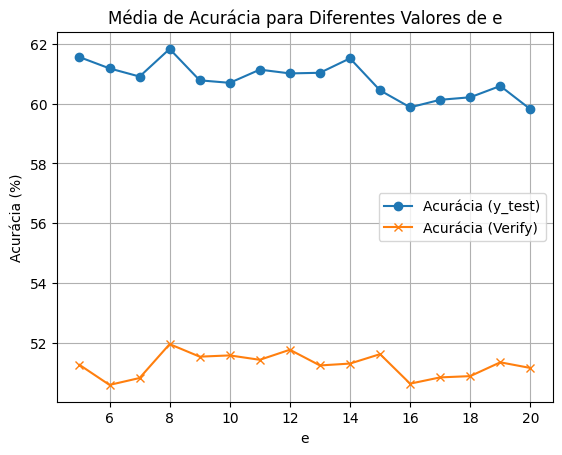

In [24]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score
import winsound

# Definir o número de divisões para a validação cruzada
n_splits = 5

# Criar listas para armazenar os resultados gerais
all_predictions = []
all_verify_values = []
all_actual_values = []
all_accuracy_scores_ytest = []
all_accuracy_scores_verify = []

# Criar uma lista para armazenar as médias das acurácias por e
mean_accuracy_by_e = []

# Loop para cada e em n_list e realização de validação cruzada em série temporal
for e in e_list:
    # Definir as features (X), o target (y) e a verificação (verify) dinamicamente
    X = price_data[['RSI',
                    f'k_percent_{t}',
                    f'r_percent_{t}',
                    f'Price_Rate_Of_Change_{e}',
                    'MACD',
                    'MACD_EMA',
                    'On Balance Volume']]
    y = price_data['Prediction']
    verify = price_data['Verify']

    # Remover possíveis valores NaN nas colunas selecionadas
    data = pd.concat([X, y, verify], axis=1).dropna()
    X = data.iloc[:, :-2]
    y = data.iloc[:, -2]
    verify = data.iloc[:, -1]

    # Configurar o TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Listas para armazenar as acurácias por fold para esse e
    accuracy_scores_ytest_fold = []
    accuracy_scores_verify_fold = []



    print(f'e: {e}')
    fold = 1
    for train_index, test_index in tscv.split(X):
        # Dividir os dados em treino e teste com base nos índices
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        y_verify = verify.iloc[test_index]

        # Criar o modelo de Random Forest
        rand_frst_clf = RandomForestClassifier(n_estimators=100, criterion="gini", random_state=0, oob_score=True)

        # Ajustar o modelo aos dados de treino
        rand_frst_clf.fit(X_train, y_train)

        # Fazer previsões nos dados de teste
        y_pred = rand_frst_clf.predict(X_test)

        # Armazenar as predições e valores reais para análise posterior
        all_predictions.extend(y_pred)
        all_verify_values.extend(y_verify.values)
        all_actual_values.extend(y_test.values)

        # Calcular acurácia para y_test e verify
        accuracy_ytest = accuracy_score(y_test, y_pred) * 100.0
        accuracy_verify = accuracy_score(y_verify, y_pred) * 100.0

        # Armazenar as acurácias por fold
        accuracy_scores_ytest_fold.append(accuracy_ytest)
        accuracy_scores_verify_fold.append(accuracy_verify)

        # Exibir resultados por fold
        print(f'Fold {fold}:')
        print(f' - Correct Prediction (y_test): {accuracy_ytest:.2f}%')
        print(f' - Correct Prediction (Verify): {accuracy_verify:.2f}%')
        fold += 1

    # Calcular a média de acurácia por e
    mean_accuracy_ytest = np.mean(accuracy_scores_ytest_fold)
    mean_accuracy_verify = np.mean(accuracy_scores_verify_fold)
    mean_accuracy_by_e.append((e, mean_accuracy_ytest, mean_accuracy_verify))

    print(f'Média de acurácia (y_test) para e {e}: {mean_accuracy_ytest:.2f}%')
    print(f'Média de acurácia (Verify) para e {e}: {mean_accuracy_verify:.2f}%')
    print('---')

# Exibir o resumo geral das médias
print("Resumo geral das médias:")
for e, acc_ytest, acc_verify in mean_accuracy_by_e:
    print(f'e: {e} - Média Acurácia (y_test): {acc_ytest:.2f}% - Média Acurácia (Verify): {acc_verify:.2f}%')

# Opcional: Plotando as médias por e
import matplotlib.pyplot as plt

e_values, acc_ytest_values, acc_verify_values = zip(*mean_accuracy_by_e)

plt.plot(e_values, acc_ytest_values, label='Acurácia (y_test)', marker='o')
plt.plot(e_values, acc_verify_values, label='Acurácia (Verify)', marker='x')
plt.title("Média de Acurácia para Diferentes Valores de e")
plt.xlabel('e')
plt.ylabel('Acurácia (%)')
plt.legend()
plt.grid(True)
plt.show()
winsound.Beep(440, 300)